# Lista 1: EDA
1. Pobieramy zbiór danych

In [103]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold, KFold
import itertools
import xgboost as xgb

In [104]:
bank_marketing = fetch_ucirepo(id=222)

X = bank_marketing.data.features
y = bank_marketing.data.targets

# Od razu dokonujemy podziału na train test val
X = X.sample(frac=1, random_state=42)  # tasujemy dane
y = y.loc[X.index] # dopasowujemy y do przetasowanego X

n = len(X)
train_end = int(n * 0.8)
val_end = int(n * 0.9)

X_train = X.iloc[:train_end] # narazie reszty nie potrzebujemy, dorobimy później

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# zobaczmy jak to wygląda
print(X.head(3))
print(y.head(3))

print(bank_marketing.metadata)
print(bank_marketing.variables)

   age          job  marital  education default  balance housing loan  \
0   40  blue-collar  married  secondary      no      580     yes   no   
1   47     services   single  secondary      no     3644      no   no   
2   25      student   single   tertiary      no      538     yes   no   

    contact  day_of_week month  duration  campaign  pdays  previous poutcome  
0       NaN           16   may       192         1     -1         0      NaN  
1       NaN            9   jun        83         2     -1         0      NaN  
2  cellular           20   apr       226         1     -1         0      NaN  
    y
0  no
1  no
2  no
{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscr

Zbiór danych to informacje o klientach, którzy rozmawiali z pracownikami banku próbującymi nakłonić do wzięcia kredytu. Naszą etykietą binarną jest odpowiedź, czy dany klient po rozmowie taki kredyt wziął czy też nie.

### Mamy tutaj 16 cech:
Numeryczne:
- age - wiek
- balance - roczny dochód
- duration - długość rozmowy
- campaing - ile razy klient rozmawiał z bankiem (wliczając tą ostatnią)
- pdays - ile dni minęło od poprzedniej rozmowy z klientem (-1 jeżeli to pierwsza)
- previous - liczba rozmów odbyta przed tą ostatnią

Binarne:
- default - czy klient ma niespłacony kredyt
- housing - czy ma kredyt na mieszkanie
- loan - czy ma kredyt osobisty 

Kategoryczne:
- job - zawód 
- marital - status małżeński
- education - wykształcenie
- contact - czym się kontaktował klient (telefon komórkowy vs stacjonarny)
- poutcome - efekt poprzedniej rozmowy (porażka/sukces/nieistniała)

Daty:
- day of week - dzień tygodnia ostatniej rozmowy
- month - miesiąc ostatniej rozmowy (kategorycznie, 3 pierwsze litery miesiąca)

Po samym przeczytaniu czym są cechy od razu widzimy że część z nich ze sobą koreluje, bądź jest niepotrzebna a nawet szkodząca dla modelu ale o tym później.

In [105]:
# Sprawdzenie liczby pustych rekordów (NaN) w każdej kolumnie
print(X.isna().sum())

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64


### Puste rekordy:
Z bank_marketing.variables widzimy, że poutcome i pdays mają brakujące wartości, przy czym poutcome oznaczamy  jako Nan, a pdays jako -1. (przeczytałem opis datasetu, nie licząc pdays wszystkie brakujące rekordy zapisywane są jako NaN)
Odnoszą się one do faktu, że dany klient nie kontatkował się z bankiem wcześniej niż ten raz gdy zebrano dane. oczywiście cechy takie jak previous też do tego nawiązują, ale że jest to cecha numeryczna to po prostu mają wtedy wartość zero.


Dodatkowo z kodu powyżej widzimy że kolumny job, education, i contact posiadają puste rekordy, którymi będziemy się musieli zająć. W odróżnieniu od dwóch cech wspomnianych wyżej, te są po prostu brakami do naprawy.

### Korelacje:
Sprowadzimy  wsxzystkie dane do wartości liczbowych, po czym wykonamy testy statystyczne aby znaleźć korelacje między cechami

1. 
job, education oraz contact uzupełnimy w oparciu o rozkład prawdopodobieństwa kategorii w pełych rekordach tych cech, aby nie wzmacniać jednej, naczęstszej/najśredniejszej wartoś

In [106]:
def fillna_with_distribution(df, columns):
	for col in columns:		# rozkad liczymy na x_train
		value_counts = X_train[col].value_counts(normalize=True, dropna=True)
		missing = df[col].isna()
		if missing.sum() > 0:
			filled_values = np.random.choice(
				value_counts.index,
				size=missing.sum(),
				p=value_counts.values
			)
			df.loc[missing, col] = filled_values
	return df

X = fillna_with_distribution(X, ['job', 'education', 'contact'])


2. 
poutcome zawsze daje Nan, gdy klient nie rozmawiał wcześniej z bankiem, więc można dodać do poutcome kategorię "none" zastępującą Nan, gdy rozmówca miał do czynienia z bankiem tylko ten jeden raz.

In [107]:
mask = (X['poutcome'].isna())
X.loc[mask, 'poutcome'] = 'none'

3.
-1 troche odstaje wartością od reszty liczb w pdays. Stworzymy nową kolumnę: Is_first_time, która nam powie czy klient rozmawia z bankiem pierwszy raz czy też kolejny (cecha binarna), a -1 w starej kolumnie wykonujemy imputację knn.

In [108]:
X['is_first_time'] = (X['pdays'] == -1).astype(int)

# Zamień -1 na np.nan w pdays
for df in [X_train, X]:
    df['pdays'] = df['pdays'].replace(-1, np.nan)

# Fit imputer tylko na X_train
imputer = KNNImputer(n_neighbors=5)
imputer.fit(X_train[['pdays']])

# wrzucamy do X_knn dla sprawdzenia jak dziala
X_knn = X.copy()
X_knn['pdays'] = imputer.transform(X_knn[['pdays']])
print(X_knn.isna().sum())

age              0
job              0
marital          0
education        0
default          0
balance          0
housing          0
loan             0
contact          0
day_of_week      0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome         0
is_first_time    0
dtype: int64


In [109]:
X_knn.head(10)
X_knn['pdays'].unique()

array([223.55072899, 336.        , 370.        , 106.        ,
       213.        , 105.        , 352.        ,  91.        ,
       337.        , 110.        ,  26.        , 364.        ,
       178.        , 269.        , 340.        , 275.        ,
       190.        ,  14.        , 267.        , 185.        ,
       363.        , 250.        , 140.        , 175.        ,
       248.        , 461.        , 368.        , 181.        ,
       132.        , 341.        , 183.        ,  94.        ,
       309.        , 348.        , 224.        ,  97.        ,
       361.        , 369.        , 153.        , 294.        ,
       144.        , 355.        , 167.        , 287.        ,
       192.        , 195.        , 232.        , 357.        ,
       171.        , 362.        ,  28.        , 254.        ,
       107.        , 165.        , 184.        , 307.        ,
       592.        , 180.        , 457.        ,  98.        ,
       272.        , 286.        , 343.        , 160.  

Z tego co widzę to ten knn tak średnio zadziałał, bo wszystkie -1 zamienił na jakąś tam wartość zamiast robić osobne wartości w zależności od sąsiedztwa co pewnie jest spowodowane tym, że większość wartości to -1. Zostaniemy w takim razie przy medianie policzonej na zbiorze testowym.

In [110]:
median_pdays = X_train.loc[X_train['pdays'].notna(), 'pdays'].median()
X.loc[X['pdays'].isna(), 'pdays'] = median_pdays.round(0)
X['pdays'] = X['pdays'].astype(int)
print(f"Mediana pdays z X_train: {median_pdays}")
print(X['pdays'].isna().sum())

Mediana pdays z X_train: 194.0
0


Tera jest git. Następna w kolejności jest konwersja wszystkich wartości na liczby, głównie chodzi o cechy binarne i kategoryczne, zobaczmy jak to narazie wygląda:

In [111]:
X.head(2)

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,is_first_time
0,40,blue-collar,married,secondary,no,580,yes,no,cellular,16,may,192,1,194,0,none,1
1,47,services,single,secondary,no,3644,no,no,cellular,9,jun,83,2,194,0,none,1


Dla job,marital,default,housing,loan,contact zrobimy one hot encoding , dla education zrobimy label encoding bo wyksztasłcenie jest w postaci hierarchii a month oraz day_of_week zrobimy jako cyclic encoding, dodając tabelę monnth sin i month cos

In [112]:
# One-hot encoding 
dummy_cols = ['job', 'marital', 'poutcome']
X = pd.get_dummies(X, columns=dummy_cols, drop_first=False)

for col in ['default', 'housing', 'loan','contact']:
    if col == 'contact': 
        X[col] = X[col].map({'telephone': 1, 'cellular': 0})
    else:
        X[col] = X[col].map({'yes': 1, 'no': 0})


# label encoding dla education: 0 - primary, 1 - secondary, 2 - tertiary
enc_education = LabelEncoder()
X['education'] = enc_education.fit_transform(X['education'])

# cyclic encoding dla month
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_to_num = {month: idx for idx, month in enumerate(months)}
X['month_num'] = X['month'].map(month_to_num)
X['month_sin'] = np.sin(2 * np.pi * X['month_num'] / 12)
X['month_cos'] = np.cos(2 * np.pi * X['month_num'] / 12)

X = X.drop(columns=['month', 'month_num'])

X['day_sin'] = np.sin(2 * np.pi * X['day_of_week'] / 31)
X['day_cos'] = np.cos(2 * np.pi * X['day_of_week'] / 31)
X = X.drop(columns=['day_of_week'])

In [113]:
pd.set_option('display.max_columns', None)
X.info()
X.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                45211 non-null  int64  
 1   education          45211 non-null  int64  
 2   default            45211 non-null  int64  
 3   balance            45211 non-null  int64  
 4   housing            45211 non-null  int64  
 5   loan               45211 non-null  int64  
 6   contact            45211 non-null  int64  
 7   duration           45211 non-null  int64  
 8   campaign           45211 non-null  int64  
 9   pdays              45211 non-null  int64  
 10  previous           45211 non-null  int64  
 11  is_first_time      45211 non-null  int64  
 12  job_admin.         45211 non-null  bool   
 13  job_blue-collar    45211 non-null  bool   
 14  job_entrepreneur   45211 non-null  bool   
 15  job_housemaid      45211 non-null  bool   
 16  job_management     452

,age,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,is_first_time,month_sin,month_cos,day_sin,day_cos
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,4.521100e+04,45211.000000,45211.000000
mean,40.936210,1.149057,0.018027,1362.272058,0.555838,0.160226,0.091394,258.163080,2.763841,199.584482,0.580323,0.817367,0.251128,-3.980684e-01,0.027214,-0.106996
std,10.618762,0.665590,0.133049,3044.765829,0.496878,0.366820,0.288171,257.527812,3.098021,50.686537,2.303441,0.386369,0.640129,6.072296e-01,0.698901,0.706661
min,18.000000,0.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-0.998717,-0.994869
25%,33.000000,1.000000,0.000000,72.000000,0.000000,0.000000,0.000000,103.000000,1.000000,194.000000,0.000000,1.000000,-0.500000,-8.660254e-01,-0.651372,-0.758758
50%,39.000000,1.000000,0.000000,448.000000,1.000000,0.000000,0.000000,180.000000,2.000000,194.000000,0.000000,1.000000,0.500000,-5.000000e-01,-0.101168,-0.250653
75%,48.000000,2.000000,0.000000,1428.000000,1.000000,0.000000,0.000000,319.000000,3.000000,194.000000,0.000000,1.000000,0.866025,6.123234e-17,0.724793,0.528964
max,95.000000,2.000000,1.000000,102127.000000,1.000000,1.000000,1.000000,4918.000000,63.000000,871.000000,275.000000,1.000000,1.000000,1.000000e+00,0.998717,1.000000


Wszystkie dane mamy zapisane jako liczby, to teraz możemy poszukać korelacji i outlierów oraz kolumn, które nie są potrzebne do nauki.

4. 
Korelacje

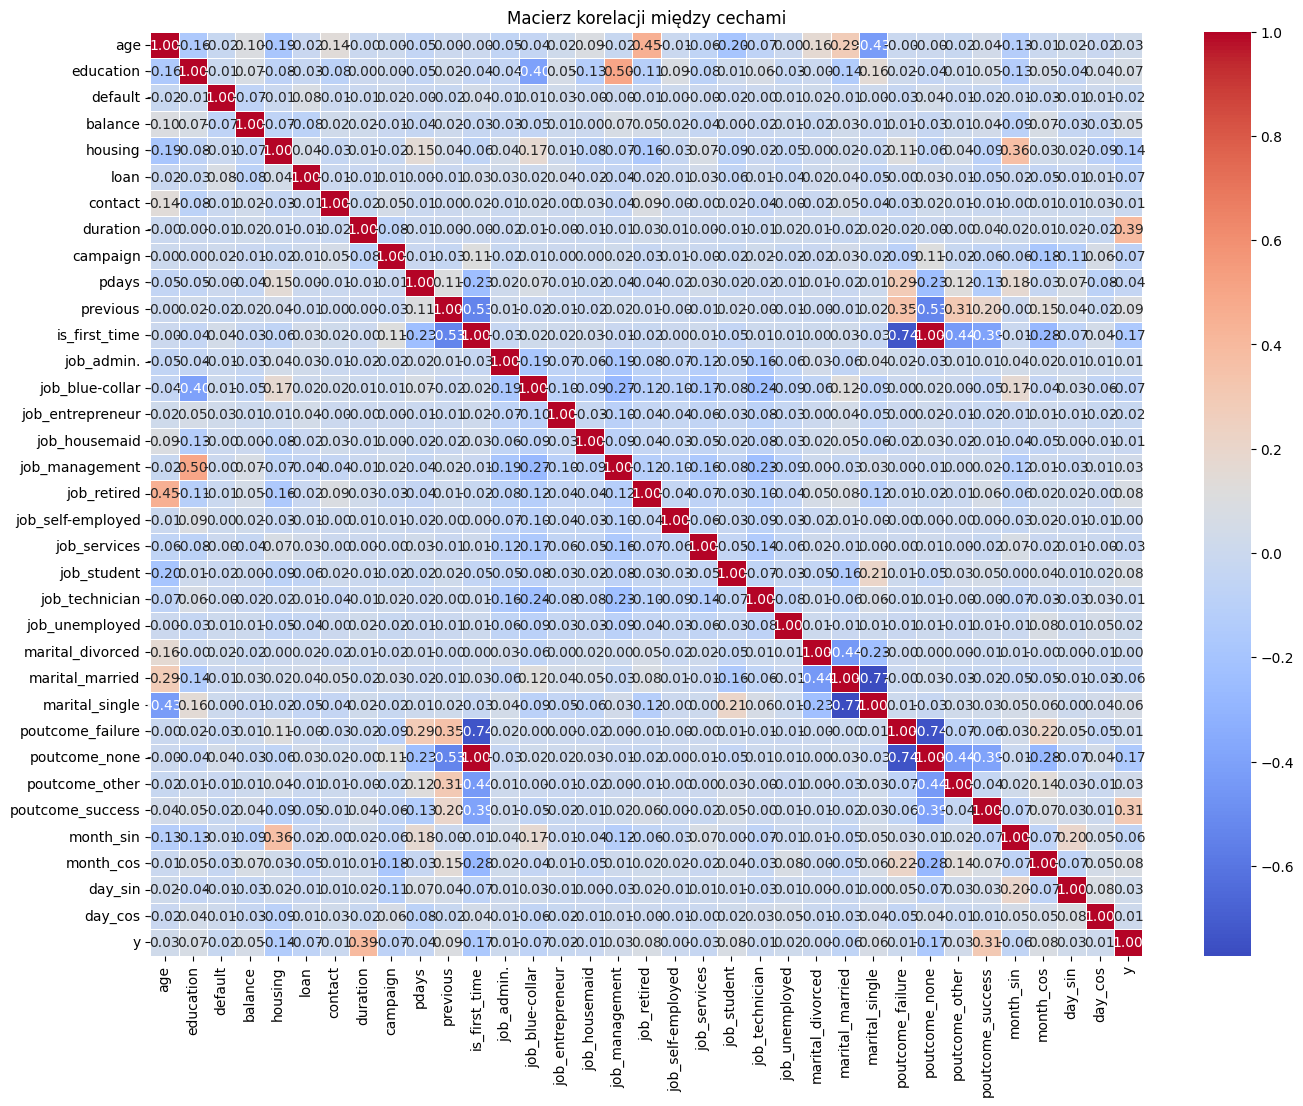

In [114]:
X_corr = X.copy()
X_corr['y'] = y['y'].map({'yes': 1, 'no': 0})    # chcemy zobaczyc tez korelacje z targetem
plt.figure(figsize=(16, 12))
sns.heatmap(X_corr.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Macierz korelacji między cechami")
plt.show()


- Usuwamy duration bo mocno koreluje z y a przed rozmową i tak nie jesteśmy w stanie go znać wiec useless
- Usuwamy poutcome_none i pdays bo mamy is_first time i previous
- Usuwamy marital_married aby zredukować korelację w kolumnach marital
- wszystkie poutcome korelują z is_first_time więc go usunę, jednak dodanie go nie było potrzebne

narazie tyle, najwyżej potem coś jeszcze zmienimy
 


In [115]:
X.drop(columns=['duration','poutcome_none','is_first_time','marital_married','pdays'], inplace=True)  

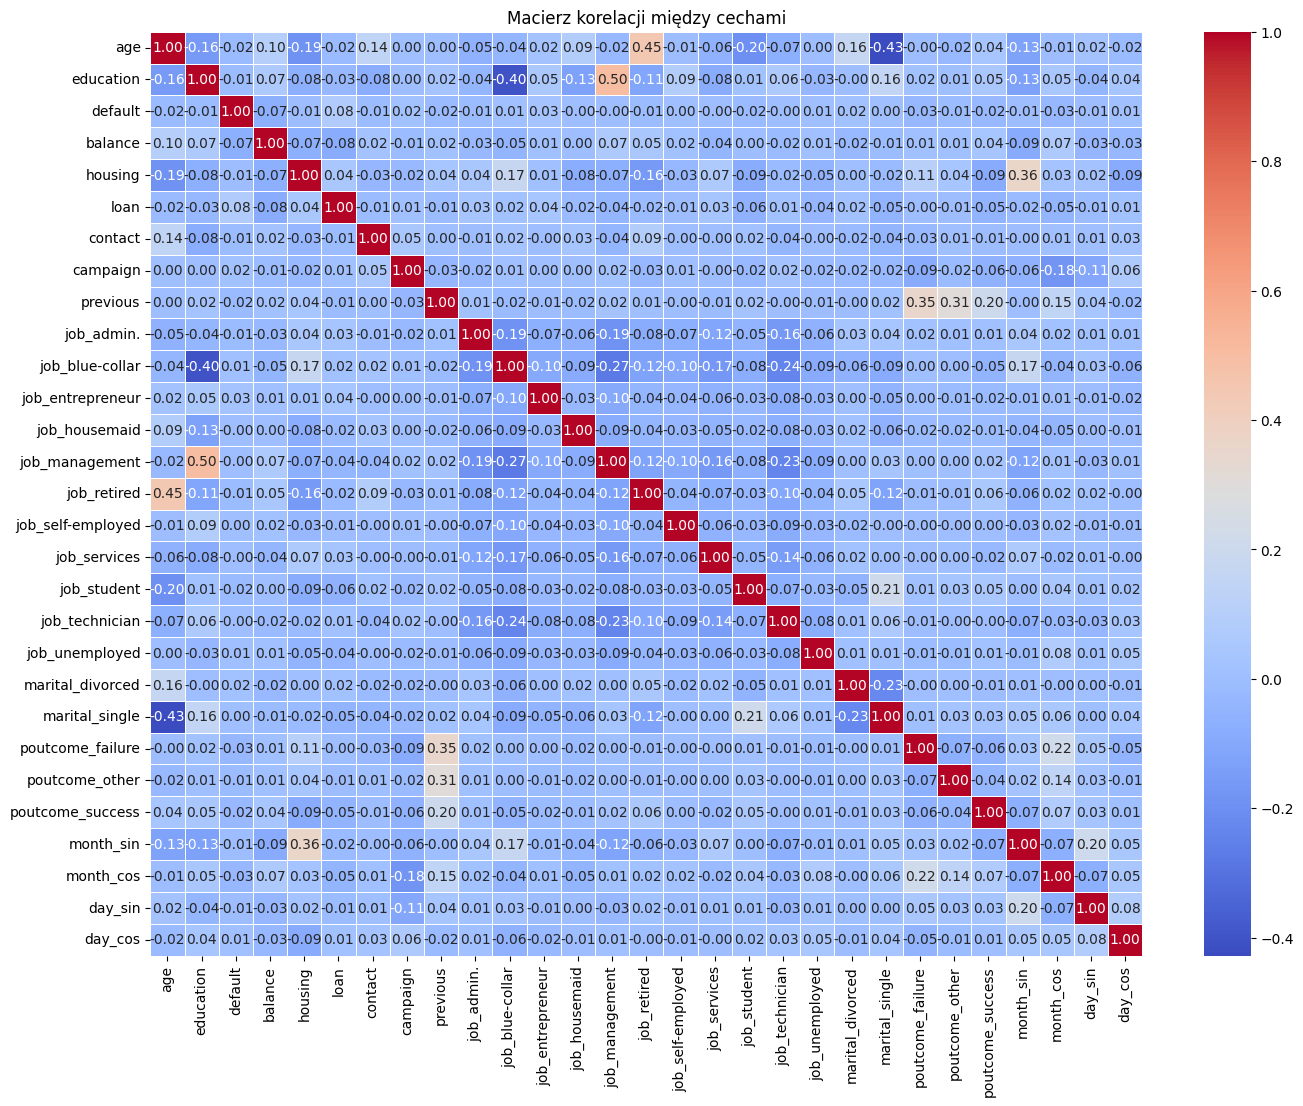

In [116]:
plt.figure(figsize=(16, 12))
sns.heatmap(X.corr(), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Macierz korelacji między cechami")
plt.show()

### Outliery
Zobaczmy wartości odstające danych

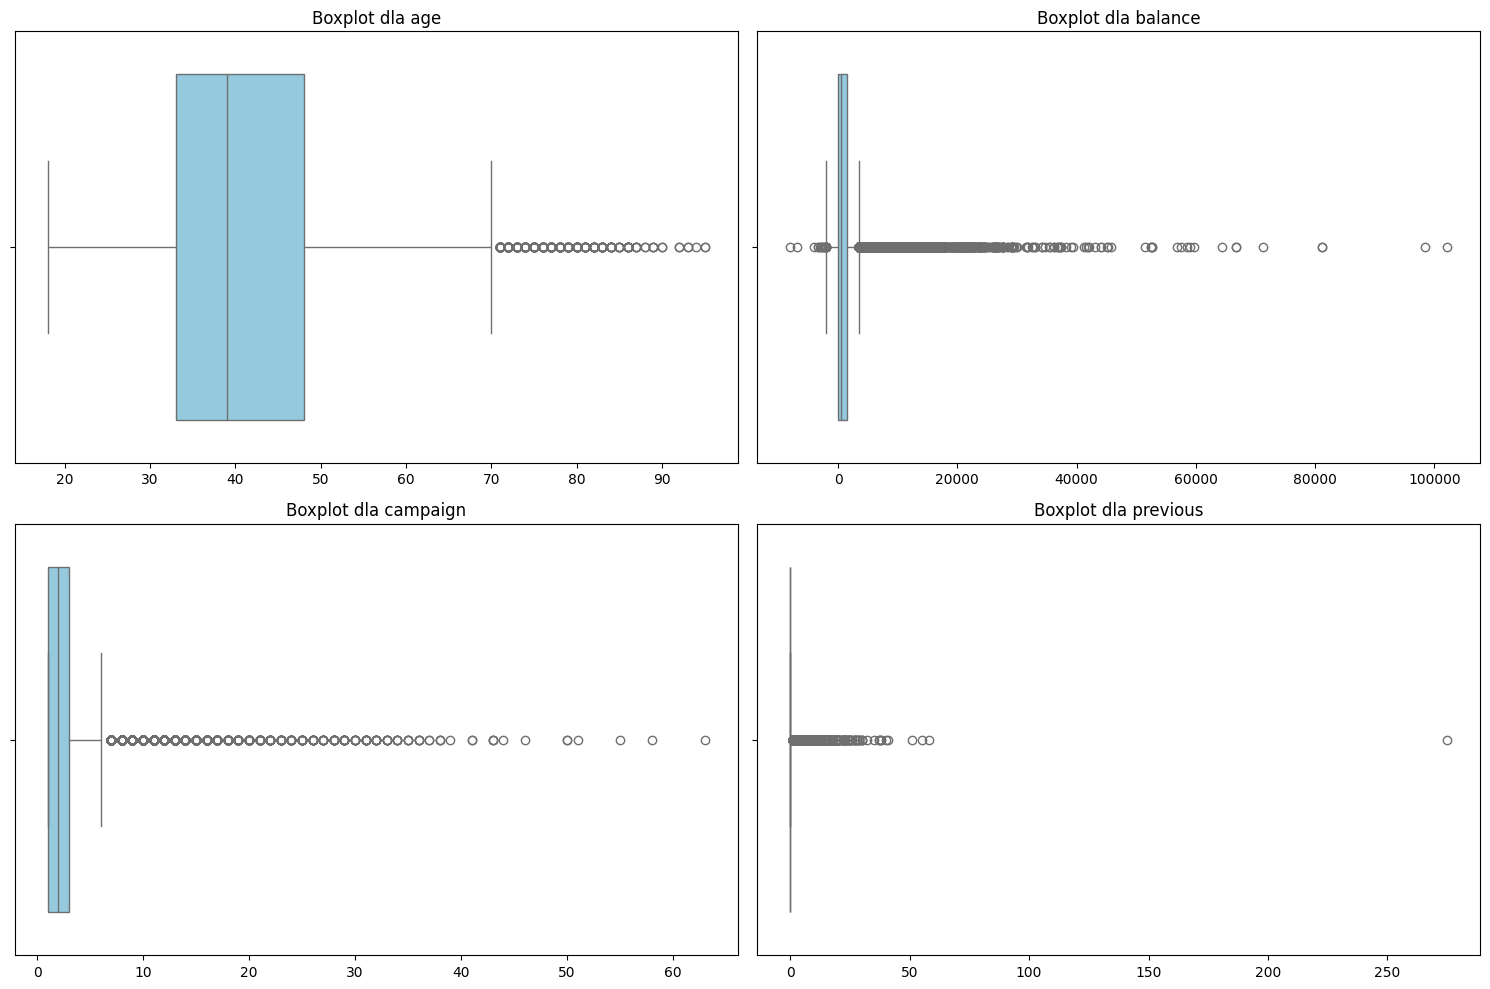

In [117]:
numerical_cols = ['age', 'balance', 'campaign', 'previous']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=X[col], color='skyblue')
    plt.title(f'Boxplot dla {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()

Wiek - wygląda naturalnie, większość osób do ludzie od 30 do 50 lat, ale wartości w przedziale 70-100 też są realne, kredyt brali emeryci

Balance - o ile outliery w postaci zarobków 100k pln są realne, jako pojedyńcze jednostki, to wartości ujemne są zastanawiające, zakładając że klienci nie są w długach to jest to raczej błąd, musimy go naprawić

Previous - nie ma opcji, że ktoś rozmawiał prawie 300 razy z bankiem, usuniemy ten  pojedyńczy rekord, reszta wygląda git

Campaign - No generalnie wątpię że dzwonienie po 50 razy do kogoś jest mądre wiec te wartości odstające są podejrzane i trzeba się im przypatrzeć.

1. Campaign - usuniemy odstający górny percentyl >99%

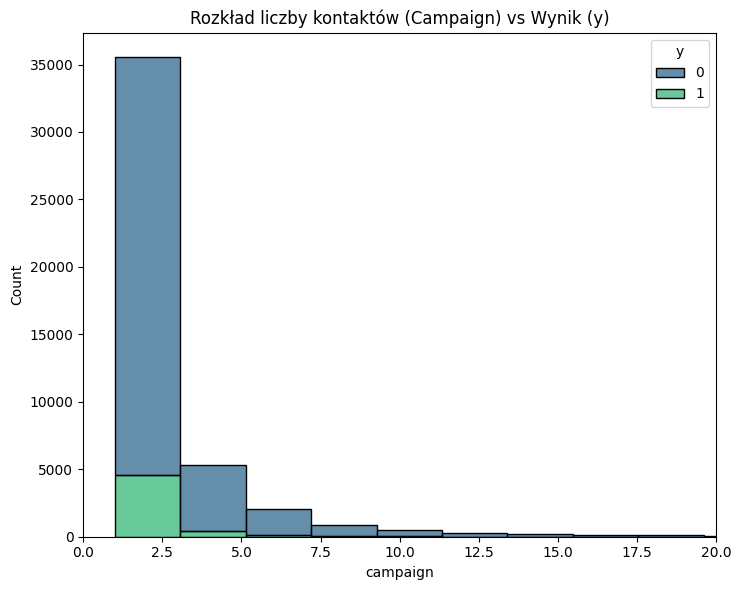

In [118]:

X_temp_plot = X.copy()
X_temp_plot['y'] = y['y'].map({'yes': 1, 'no': 0})

plt.figure(figsize=(14, 6))

# Rozkład liczby kontaktów w podziale na sukces/porażkę
plt.subplot(1, 2, 1)
sns.histplot(data=X_temp_plot, x='campaign', hue='y', multiple='stack', bins=30, palette='viridis')
plt.title('Rozkład liczby kontaktów (Campaign) vs Wynik (y)')
plt.xlim(0, 20) # Ograniczamy widok do 20, bo dalej jest mało danych
plt.tight_layout()
plt.show()

widzimy, że najbardziej udany marketing jest dla campaing w przedziale 1-10 a szczególnie w przedziale 1-3


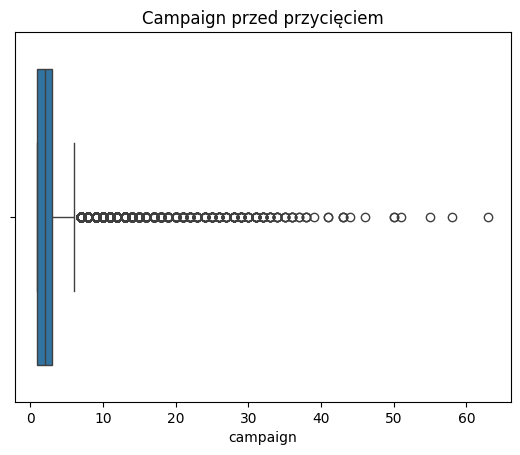

Przycięto wartości campaign powyżej 99. centyla.


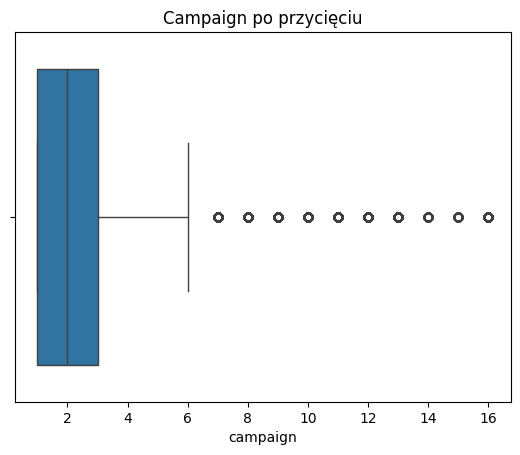

In [119]:
sns.boxplot(x=X['campaign'])
plt.title("Campaign przed przycięciem")
plt.show()


q99 = X['campaign'].quantile(0.99)
X.loc[X['campaign'] > q99, 'campaign'] = q99

print("Przycięto wartości campaign powyżej 99. centyla.")
sns.boxplot(x=X['campaign'])
plt.title("Campaign po przycięciu")
plt.show()

2. Balance - Załóżmy, że wartości ujemne są błędem i taki klient po prostu nic nie zarobił przez rok, resztę danych przemielimy przez logarytm, to najpewniej spowoduje, że przy 0 będzie skok, bo zbierze wszystkie rekordy ujemne ale reszta rekordów powinna się nieźle ułożyć. Jeżeli model nie będzie dawać dobrych efektów potencjalnie cofniemy się do tego miejsca i uwzględnim negatywne rekordy.

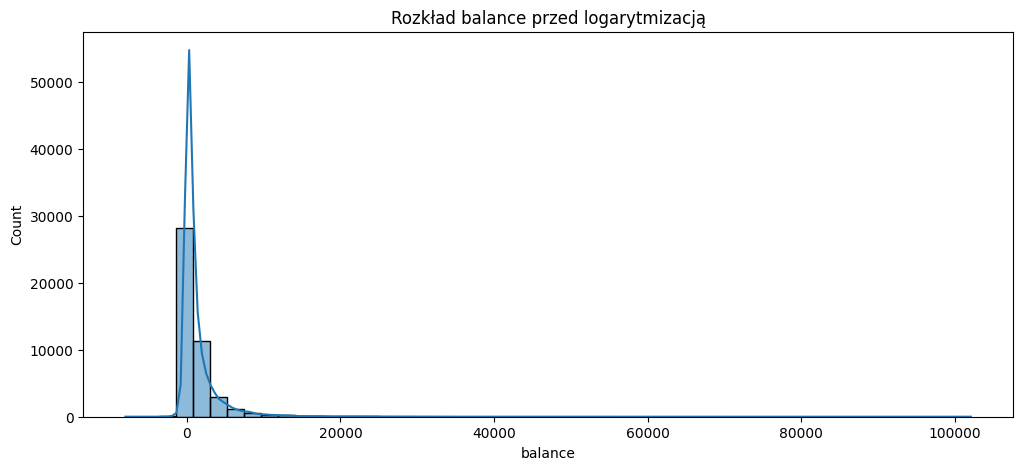

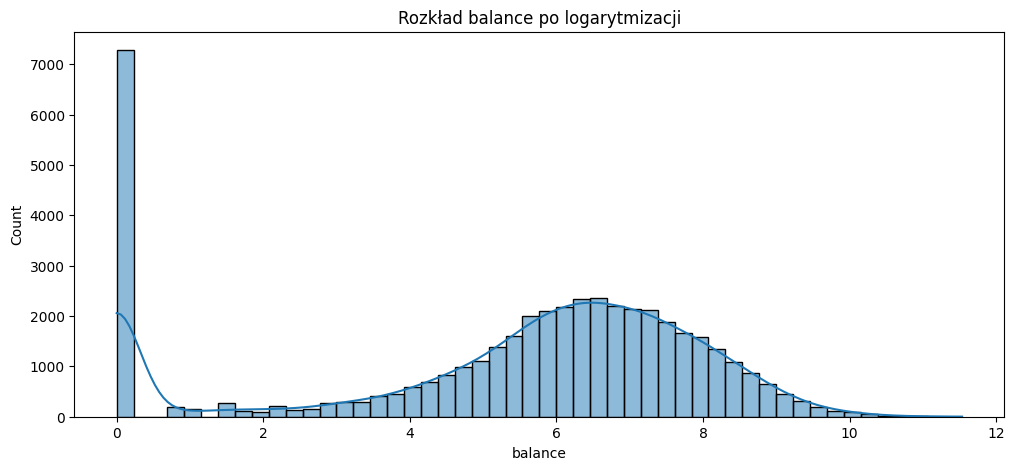

In [120]:
plt.figure(figsize=(12, 5))
sns.histplot(X['balance'], bins=50, kde=True)
plt.title("Rozkład balance przed logarytmizacją")
plt.show()

X.loc[X['balance'] < 0, 'balance'] = 0

# Transformacja logarytmiczna 
X['balance'] = np.log1p(X['balance'])


plt.figure(figsize=(12, 5))
sns.histplot(X['balance'], bins=50, kde=True)
plt.title("Rozkład balance po logarytmizacji")
plt.show()

3. Previous - rozkład wygląda okej, jedynie co można zrobić to usunąć ten jeden odstający rekord bo to nie jest raczej realna i merytoryczna wartość warta przetworzenia
dodatkowo to też można przerzucić przez logarytm to sie rozkład zrobi ładniejszy

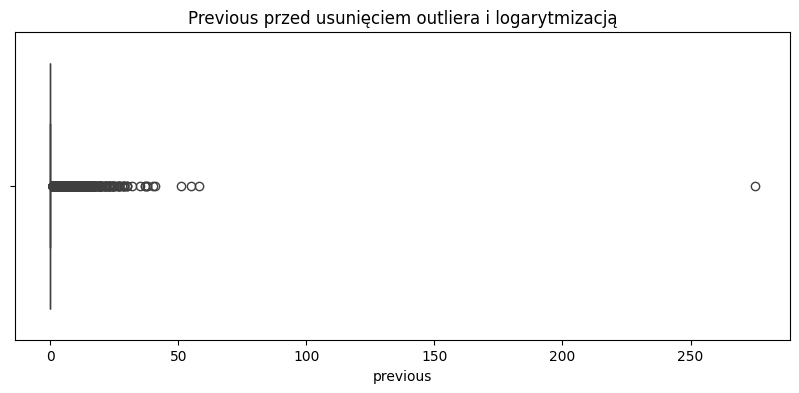

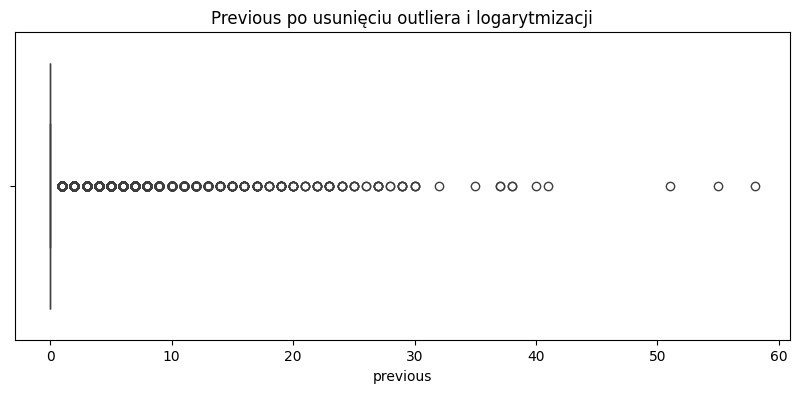

In [121]:
plt.figure(figsize=(10, 4))
sns.boxplot(x=X['previous'])
plt.title("Previous przed usunięciem outliera i logarytmizacją")
plt.show()

mask = X['previous'] < 100
X = X[mask]
y = y[mask]


plt.figure(figsize=(10, 4))
sns.boxplot(x=X['previous'])
plt.title("Previous po usunięciu outliera i logarytmizacji")
plt.show()

### Standaryzacja
Ostatnie co nam zostało to konwersja wartości ale zanim to zrobimy to można wydzielić nowy podział datasetu na train test val, stary był zrobiony wyłącznie aby operować na danych treningowych przy liczeniu mediany itp ale nie wprowadzaliśmy do niego zmian, więc musimy je na tych zbiorach zaaplikować.
Po podziale, użyjemy standard scallera dla age, balance, campaign i previous, reszta cech jest albo binarna, albo mieści się w przedziale -1 do 1 więc je zostawiamy.

In [122]:
# teraz dzielimy dataset na train, val, test tak jak wcześniej
train_end = int(len(X) * 0.8)
val_end = int(len(X) * 0.9)

X_train = X.iloc[:train_end].copy()
X_val   = X.iloc[train_end:val_end].copy()
X_test  = X.iloc[val_end:].copy()

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

y_numeric = y.copy()
y_numeric['y'] = y_numeric['y'].map({'yes': 1, 'no': 0})
y_train = y_numeric.iloc[:train_end]
y_val   = y_numeric.iloc[train_end:val_end]
y_test  = y_numeric.iloc[val_end:]

scaler = StandardScaler()
cols_to_scale = ['age', 'balance', 'campaign', 'previous']

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_val[cols_to_scale]   = scaler.transform(X_val[cols_to_scale])
X_test[cols_to_scale]  = scaler.transform(X_test[cols_to_scale])

X_train.head(3)

,age,education,default,balance,housing,loan,contact,campaign,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_single,poutcome_failure,poutcome_other,poutcome_success,month_sin,month_cos,day_sin,day_cos
0,-0.084461,1.0,0.0,0.377502,1.0,0.0,0.0,-0.655973,-0.299894,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.866025,-5.000000e-01,-0.101168,-0.994869
1,0.574083,1.0,0.0,1.036129,0.0,0.0,0.0,-0.267207,-0.299894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.500000,-8.660254e-01,0.968077,-0.250653
2,-1.495627,2.0,0.0,0.350590,1.0,0.0,0.0,-0.655973,-0.299894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,6.123234e-17,-0.790776,-0.612106


Teraz w końcu możemy przejść do modeli

# MODELE
- regresja logistyczna
- sieć neuronowa
- XGboost

### Regresja logistyczna:

In [123]:
y_train_ = y_train.values.ravel().astype(int)
y_val_ = y_val.values.ravel().astype(int)
y_test_ = y_test.values.ravel().astype(int)

def log_reg_model(iter = 1000,penalty = 'l2'):
    log_reg = LogisticRegression(max_iter=iter, random_state=42, penalty=penalty, solver='saga',class_weight='balanced',l1_ratio=0.5 if penalty=='elasticnet' else None)
    log_reg.fit(X_train, y_train_)

    y_pred = log_reg.predict(X_test)
    return y_pred



In [98]:
len(X_train),len(y_train_)


(36168, 36168)

In [124]:
y_test = log_reg_model(1000,'l2')
print(f"Accuracy (Dokładność): {accuracy_score(y_test_, y_test):.4f}")
print("\nRaport klasyfikacji:")
print(classification_report(y_test_, y_test))

Accuracy (Dokładność): 0.7299

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      3995
           1       0.24      0.62      0.35       526

    accuracy                           0.73      4521
   macro avg       0.59      0.68      0.59      4521
weighted avg       0.86      0.73      0.77      4521



wynik jest mocno średni albo i nawet słaby. 0.24 precyzji dla osób które zdecydowały się na kredyt to wynik niepokojący. coś tam przewiduje ale nie na tyle żeby móc mu zaufaćć. Możemy spróbować pozmieniać hiperparametry i zobaczymy czy coś się zmieni.

In [125]:
param_grid = {
    'max_iter': [100, 200, 500, 1000, 1500, 2000],
    'penalty': ['l1', 'l2', 'elasticnet']
}

# Inicjalizacja modelu
log_reg = LogisticRegression(
    solver='saga',
    class_weight='balanced',
    random_state=42,
    l1_ratio=0.5 
)

# Ustawienie 5-krotnej walidacji krzyżowej
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring='precision',
    cv=skf,
    n_jobs=-1, 
    verbose=2
)

grid_search.fit(X_train, y_train_)

print(f"\nNajlepsze parametry: {grid_search.best_params_}")
print(f"Najlepsza średnia precyzja (cross-validation): {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\RODO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1221: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(



Najlepsze parametry: {'max_iter': 100, 'penalty': 'l1'}
Najlepsza średnia precyzja (cross-validation): 0.2384


c:\Users\RODO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [126]:
y_test = log_reg_model(100,'elasticnet')
print(f"Accuracy (Dokładność): {accuracy_score(y_test_, y_test):.4f}")
print("\nRaport klasyfikacji:")
print(classification_report(y_test_, y_test))

Accuracy (Dokładność): 0.7304

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.94      0.74      0.83      3995
           1       0.24      0.62      0.35       526

    accuracy                           0.73      4521
   macro avg       0.59      0.68      0.59      4521
weighted avg       0.86      0.73      0.77      4521



No widać, że niezależnie od tych hiperparametrów, model niemalże wcale się nie zmienia, po prostu przejdźmy do następnych, bardziej zaawansowanych modeli bo regresja nie spełnia oczekiwań.

### Sieć neuronowa 
Użyjemy do tego MLP

In [127]:
device = torch.device("cpu")

In [128]:
# konwersja do tensorów
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_,dtype=torch.float32).view(-1, 1).to(device)

X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_,dtype=torch.float32).view(-1, 1).to(device)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_,dtype=torch.float32).view(-1, 1).to(device)

użyjemy  funkcji aktywacji relu, 3 warstw gdzie stosujemy batchnorm1d oraz w 1 z nich zastosujemy dropout

In [129]:
class BankModel(nn.Module):
    def __init__(self, input_dim):
        super(BankModel, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4) 
        
        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)

        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.layer1(x))))
        x = self.dropout(self.relu(self.bn2(self.layer2(x))))
        x = self.dropout(self.relu(self.bn3(self.layer3(x))))
        x = self.output(x)
        return x

input_dim = X_train.shape[1]    # liczba cech wejściowych
model = BankModel(input_dim).to(device)


Z racji że klasy są niezbalansowane (0 jest o wiele więcej niż 1) to sprawimy, aby funkcja straty uwzględniała to

In [130]:
num_neg = (y_train_ == 0).sum()
num_pos = (y_train_ == 1).sum()
pos_weight = torch.tensor([num_neg / num_pos]).to(device)

In [ ]:
device = torch.device("cpu")

lr = 0.01
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)

batch_size = 256
epochs = 100
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])   # tasujemy dane
    epoch_loss = 0

    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss/len(X_train_tensor)*batch_size:.4f}, Val Loss: {val_loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred_logits = model(X_val_tensor)
    y_pred_probs = torch.sigmoid(y_pred_logits).to(device)
    y_pred_class = (y_pred_probs > 0.5).float().numpy()
    print(classification_report(y_test_, y_pred_class))







Epoch 10/100, Train Loss: 1.0132, Val Loss: 1.0128
Epoch 20/100, Train Loss: 0.9907, Val Loss: 1.0023
Epoch 30/100, Train Loss: 0.9689, Val Loss: 0.9944
Epoch 40/100, Train Loss: 0.9587, Val Loss: 0.9940
Epoch 50/100, Train Loss: 0.9487, Val Loss: 1.0080
Epoch 60/100, Train Loss: 0.9474, Val Loss: 1.0078
Epoch 70/100, Train Loss: 0.9390, Val Loss: 1.0190
Epoch 80/100, Train Loss: 0.9388, Val Loss: 1.0042
Epoch 90/100, Train Loss: 0.9399, Val Loss: 1.0170
Epoch 100/100, Train Loss: 0.9333, Val Loss: 1.0022
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      3995
           1       0.31      0.60      0.41       526

    accuracy                           0.80      4521
   macro avg       0.62      0.71      0.64      4521
weighted avg       0.87      0.80      0.82      4521



wynik lepszy ale dalej niezadowalający, robimy walidację krzyżową na lr, optimizerze oraz liczbie epok

In [42]:
import itertools
from sklearn.metrics import f1_score

device = torch.device("cuda")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'epochs': [50, 100, 200],
    'optimizer': [optim.Adam, optim.SGD]
}

keys, values = zip(*param_grid.items())
param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

X_cv = torch.cat((X_train_tensor, X_val_tensor), 0).to(device)
y_cv = torch.cat((y_train_tensor, y_val_tensor), 0).to(device)

input_dim = X_cv.shape[1]
batch_size = 256
n_splits = 5  

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

best_avg_f1 = -1
best_params = None
results = []


for params in param_combinations:
    
    fold_f1_scores = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_cv)):
        X_train_fold = X_cv[train_idx]
        y_train_fold = y_cv[train_idx]
        X_val_fold = X_cv[val_idx]
        y_val_fold = y_cv[val_idx]

        model = BankModel(input_dim).to(device)

        optimizer_class = params['optimizer']
        optimizer = optimizer_class(model.parameters(), lr=params['lr']) 
        
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
        
        # Pętla treningowa 
        for epoch in range(params['epochs']):
            model.train()
            
            # Tasowanie danych wewnątrz folda treningowego
            permutation = torch.randperm(X_train_fold.size()[0], device=device)
            
            for i in range(0, X_train_fold.size()[0], batch_size):
                indices = permutation[i:i+batch_size]
                batch_x, batch_y = X_train_fold[indices], y_train_fold[indices]

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        # Ewaluacja 
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_fold)
            val_probs = torch.sigmoid(val_outputs)
            val_preds = (val_probs > 0.5).float() # float do tensorów
            
            f1 = f1_score(y_val_fold.cpu().numpy(), val_preds.cpu().numpy(), pos_label=1)
            fold_f1_scores.append(f1)

    avg_f1 = np.mean(fold_f1_scores)
    results.append({'params': params, 'avg_f1': avg_f1, 'std_f1': np.std(fold_f1_scores)})
    
    print(f"  -> Średni F1: {avg_f1:.4f}")

    if avg_f1 > best_avg_f1:
        best_avg_f1 = avg_f1
        best_params = params

print(f"Najlepszy średni F1-Score: {best_avg_f1:.4f}")
print(f"Najlepsze hiperparametry: {best_params}")

  -> Średni F1: 0.4245
  -> Średni F1: 0.3777
  -> Średni F1: 0.4190
  -> Średni F1: 0.3835
  -> Średni F1: 0.4045
  -> Średni F1: 0.3858
  -> Średni F1: 0.4216
  -> Średni F1: 0.3471
  -> Średni F1: 0.4284
  -> Średni F1: 0.3652
  -> Średni F1: 0.4141
  -> Średni F1: 0.3711
  -> Średni F1: 0.3811
  -> Średni F1: 0.2682
  -> Średni F1: 0.3862
  -> Średni F1: 0.2948
  -> Średni F1: 0.4097
  -> Średni F1: 0.3133
Najlepszy średni F1-Score: 0.4284
Najlepsze hiperparametry: {'lr': 0.001, 'epochs': 100, 'optimizer': <class 'torch.optim.adam.Adam'>}


Liczymy jak model z tymi hiperparametrami poradzi sobie na nowych danych

In [135]:
# coś mi sie popierzyło z użyciem cpu i cuda nie patrzcie na to xd
device = torch.device("cpu")
pos_weight = pos_weight.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)


lr = 0.001
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)

batch_size = 256
epochs = 100
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size()[0])   # tasujemy dane
    epoch_loss = 0

    for i in range(0, X_train_tensor.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss/len(X_train_tensor)*batch_size:.4f}, Val Loss: {val_loss.item():.4f}')

model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor) # test używaliśmy wcześniej, teraz leci test
    y_pred_probs = torch.sigmoid(y_pred_logits).to(device)
    y_pred_class = (y_pred_probs > 0.5).float().cpu().numpy()
    print(classification_report(y_test_, y_pred_class))


Epoch 10/100, Train Loss: 0.8884, Val Loss: 1.0458
Epoch 20/100, Train Loss: 0.8789, Val Loss: 1.0468
Epoch 30/100, Train Loss: 0.8836, Val Loss: 1.0406
Epoch 40/100, Train Loss: 0.8702, Val Loss: 1.0501
Epoch 50/100, Train Loss: 0.8785, Val Loss: 1.0488
Epoch 60/100, Train Loss: 0.8801, Val Loss: 1.0424
Epoch 70/100, Train Loss: 0.8699, Val Loss: 1.0582
Epoch 80/100, Train Loss: 0.8765, Val Loss: 1.0393
Epoch 90/100, Train Loss: 0.8725, Val Loss: 1.0622
Epoch 100/100, Train Loss: 0.8729, Val Loss: 1.0372
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      3995
           1       0.31      0.60      0.41       526

    accuracy                           0.80      4521
   macro avg       0.63      0.71      0.64      4521
weighted avg       0.87      0.80      0.82      4521



Znowu, wynik nie zmienił się za bardzo, w naszym przypadku te "domyślne" wartości hiperparametrów okazują się tymi optymalnymi jak widać, choć wiadomo że nie sprawdziliśmy wszystkiego, tylko mały kawałek możliwości. Wynik nieco lepszy niż regresja ale rozpoznanie klienta które się decyduje na kredyt dalej jest dalekie od ideału.

# XGBOOST



In [139]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

# Obliczenie wagi dla klasy pozytywnej w celu zrównoważenia klas
num_neg = (y_train_ == 0).sum()
num_pos = (y_train_ == 1).sum()
scale_pos_weight = num_neg / num_pos

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1
)

xgb_model.fit(X_train, y_train_)

y_pred_xgb = xgb_model.predict(X_test)

# Ocena modelu
print(f"Accuracy (Dokładność): {accuracy_score(y_test_, y_pred_xgb):.4f}")
print("\nRaport klasyfikacji:")
print(classification_report(y_test_, y_pred_xgb))

Accuracy (Dokładność): 0.8071

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.94      0.84      0.88      3995
           1       0.32      0.58      0.41       526

    accuracy                           0.81      4521
   macro avg       0.63      0.71      0.65      4521
weighted avg       0.87      0.81      0.83      4521



c:\Users\RODO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:20:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


wynik już na strzała jest minimalnie lepszy niż dwa poprzednie modele, chociaż wynik i wnioski pozostają takie same, może optymalizacja parametrów coś pomoże.

In [141]:
param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
}

xgb_model_cv = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search_xgb = GridSearchCV(
    estimator=xgb_model_cv,
    param_grid=param_grid_xgb,
    scoring='f1',  # Używamy F1-score jako metryki oceny
    cv=skf,
    n_jobs=-1,     # Użyj wszystkich dostępnych rdzeni procesora
    verbose=2
)


grid_search_xgb.fit(X_train, y_train_)

# Wyświetlenie najlepszych znalezionych parametrów i wyniku
print(f"\nNajlepsze parametry dla XGBoost: {grid_search_xgb.best_params_}")
print(f"Najlepszy średni F1-score: {grid_search_xgb.best_score_:.4f}")

# Ocena najlepszego modelu na zbiorze testowym
best_xgb_model = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)

print(classification_report(y_test_, y_pred_best_xgb))

Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\RODO\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [22:21:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Najlepsze parametry dla XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 300}
Najlepszy średni F1-score: 0.4456
              precision    recall  f1-score   support

           0       0.94      0.87      0.90      3995
           1       0.36      0.55      0.44       526

    accuracy                           0.83      4521
   macro avg       0.65      0.71      0.67      4521
weighted avg       0.87      0.83      0.85      4521



# Podumowanie modeli:
Po wykonaniu testów na 3 różnych modelach, najlepszy okazał się XGBoost. Nie mniej jednak wszystkie modele konsekwentnie mają problemy z predykowaniem gdy y = 1.
wykonamy na  XGboost SHAP'a w ramach dalszej analizy.

Globalna ważność cech (Mean Absolute SHAP Value):


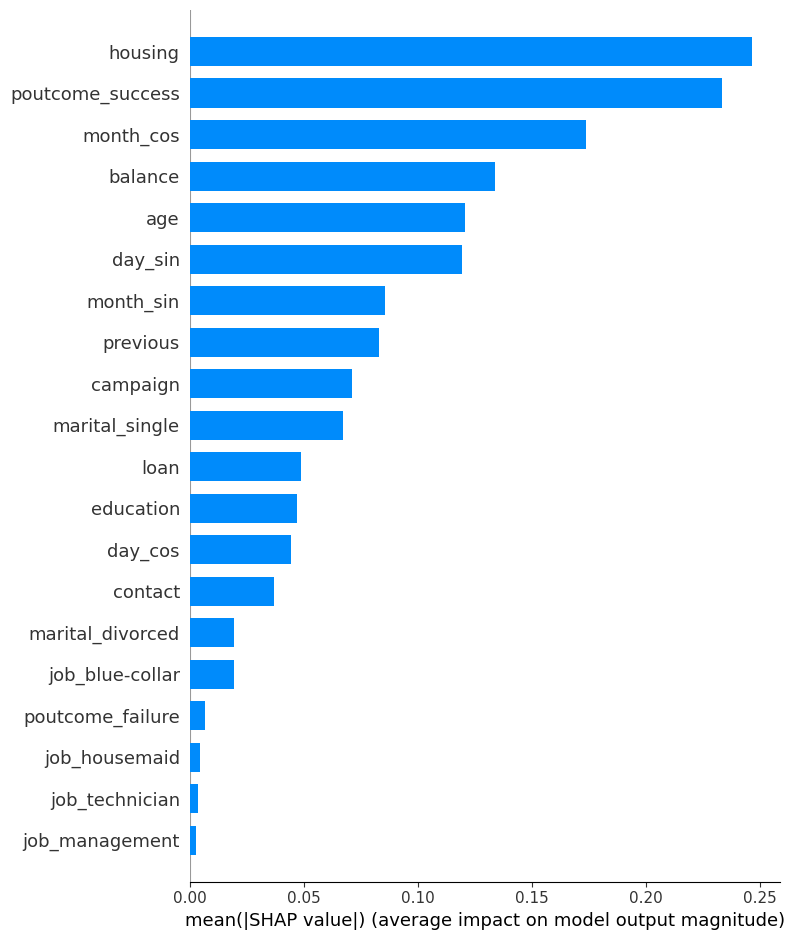


Szczegółowy wpływ cech na predykcje (Beeswarm Plot):


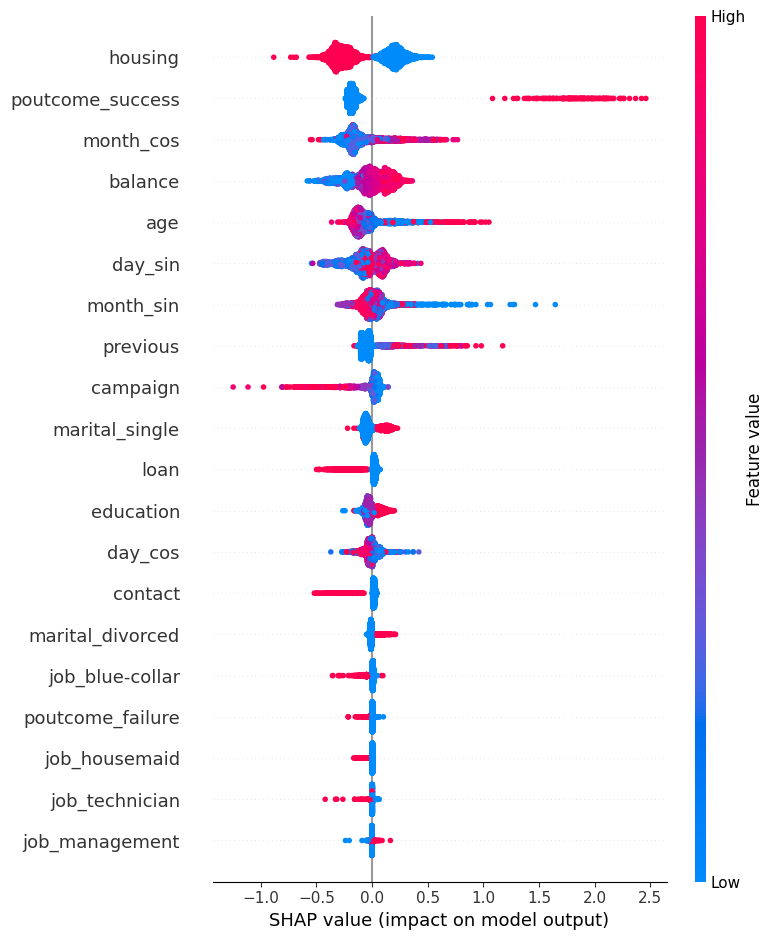


Wykres zależności dla cechy 'balance':


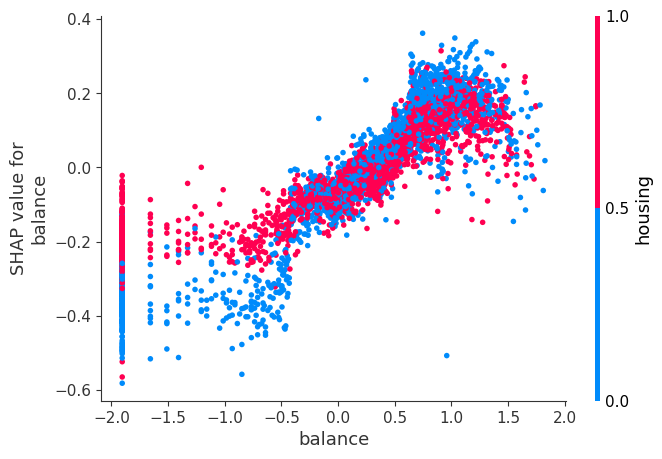

In [143]:
import shap

shap.initjs()

# Stworzenie obiektu explainer dla modelu XGBoost
explainer = shap.TreeExplainer(best_xgb_model)

# Obliczenie wartości SHAP dla zbioru testowego
shap_values = explainer.shap_values(X_test)


print("Globalna ważność cech (Mean Absolute SHAP Value):")
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()


print("\nSzczegółowy wpływ cech na predykcje (Beeswarm Plot):")
shap.summary_plot(shap_values, X_test)
plt.show()


print("\nWykres zależności dla cechy 'balance':")
shap.dependence_plot("balance", shap_values, X_test, interaction_index="auto")
plt.show()



# Podsumowanie
Shap nam pokazuje, które cechy są istotne dla modelu a które niekoniecznie. Najważniejszymi cechami tutaj jest to, czy klient już ma kredyt na mieszkanie, czy wcześniej bank już go namówił na kredyt, jego zarobki oraz miesiąc, w którym do tego doszło. Z powyższych wykresów widzimy, że największe szanse na kredyt mają osoby chociażby z dużymi zarobkami i brakiem kredytu na mieszkanie lub jeśli już w przeszłości zostali namówieni na kredyt przez ten bank. Mimo wszystko część tych cech wykazuje jednak niewielki wpływ, co potencjalnie jest do rozważenia przy poprawieniu edy, dodając nowe cechy które są na bazie tych najważniejszych cech, bądź dodanie jakichś nowych, na przykład is_in_dept, gdy balance jest ujemny, bo obecnie jedynie sprowadzamy to do zera po prostu.

Najlepszym modelem okazał się XGBoost, ale tak jak już wspominałem, on jak i wszystkie poprzednie modele mają spory problem przy klasyfikowaniu klientów którzy zdecydowali się na kredyt (y = 1). 
W celu poprawy modelu możemy przetestować więcej rodzajów jak chociażby drzewa decyzyjne + sprawdzenie większej ilości hiperparametrów. Co do danych to już wspomniałem co można zedytować, nie mniej macierz korelacji pokazuje nam, że istnieje bardzo mała korelacja między y a cechami, więc albo te cechy nie mają dużego znaczenia (co po częsci shap nam pokazał, choć z wyjątkami) i ciężko na nich się opierać, albo występują nieliniowe zależności, których jeszcze nie uwzględniliśmy i wymagają one dokładniejszej analizy.
